# Temperature calculated by DTS interrogator

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib
from obspy import UTCDateTime
from das_util import get_tstamp_dts
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})

## Step 1- Merge segemented files and Quality control

In [2]:
# %% sort and merge files
data_dir = '/data/whd01/qibin_data/England_DTS/DTS_England_channel1'
file_list = np.array(sorted(glob.glob(data_dir+'/England_Bugs_distributed_data*.csv')))
df_list = []

# %% continuous time after 10th file based on manual check 
for fname in file_list[10:]:
    df = pd.read_csv(fname, low_memory=False)
    ds = pd.to_numeric(df['Unnamed: 0'], errors='coerce')
    df = df.loc[(ds > 0) & (ds < 150)]
    df.drop(df.columns[df.columns.str.contains('unnamed',case=False)], axis=1, inplace=True)
    df_list.append(df)
df = pd.concat(df_list, axis=1)

df.to_csv(data_dir + '/merged_temperature.csv', sep=',', index=False)

In [187]:
# %% only run this cell after the previous one has been executed
df = pd.read_csv(data_dir + '/merged_temperature.csv', low_memory=False)

[UTCDateTime(2023, 3, 17, 18, 25, 47) UTCDateTime(2023, 3, 17, 18, 26, 9)
 UTCDateTime(2023, 3, 17, 18, 26, 31) ...
 UTCDateTime(2023, 3, 19, 10, 16, 15) UTCDateTime(2023, 3, 19, 10, 16, 37)
 UTCDateTime(2023, 3, 19, 10, 16, 59)]


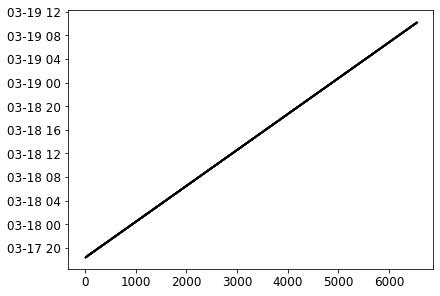

In [3]:
# check if the time of measurements is continous (linear)
time_labels = df.keys().to_numpy()
start_time = np.array([get_tstamp_dts(i) for i in time_labels])
print(start_time)
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(6,4), constrained_layout=True)
ax.scatter(np.arange(len(start_time)), start_time.astype('datetime64[s]'), marker='o', s=0.1, edgecolors='k')

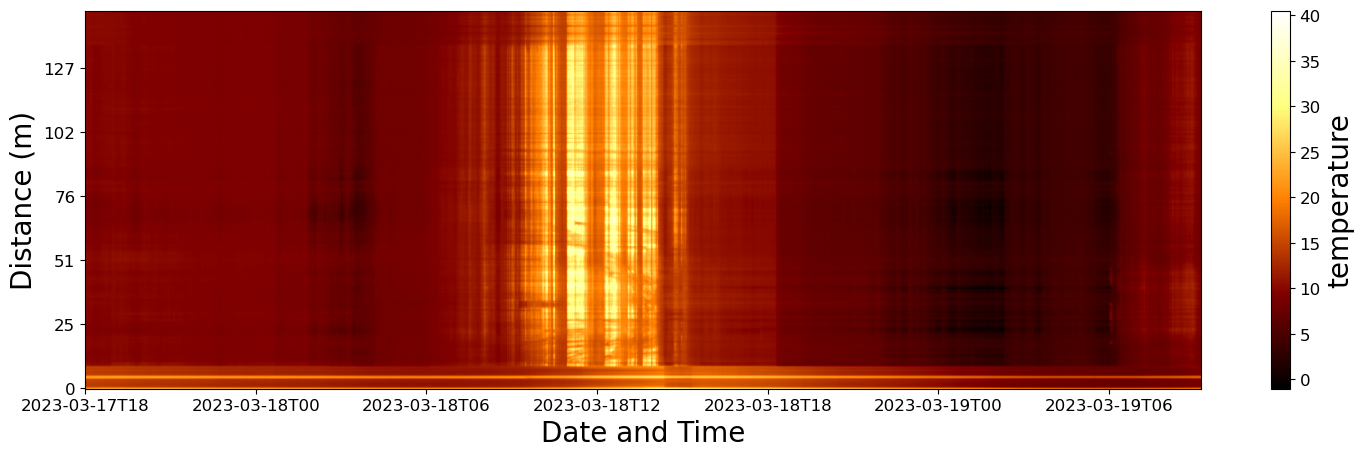

In [207]:
# %% visualize the temperature in time-space
channel_space = 0.254

plt.close('all')
plt.figure(figsize = (18, 5), dpi = 100)
plt.imshow(df.values, cmap='afmhot', aspect='auto', origin='lower')

plt.ylabel("Distance (m)", fontsize = 20)
plt.xlabel("Date and Time", fontsize = 20)
plt.xticks(np.arange(0, df.shape[1], 1000), 
           start_time[0: df.shape[1]: 1000].astype('datetime64[h]'))
plt.yticks(np.arange(0, df.shape[0], 100), 
           np.rint(np.arange(0, df.shape[0], 100) * channel_space).astype(int))
cbr = plt.colorbar()
cbr.set_label('temperature', fontsize = 20)

## Get the data for a time window

In [45]:
def get_dts(channel, starttime, endtime):
    df = pd.read_csv(data_dir + '/merged_temperature.csv', low_memory=False)
    time_labels = df.keys().to_numpy()
    start_time = np.array([get_tstamp_dts(i) for i in time_labels])
    
    time_idx = np.where(np.logical_and(start_time<endtime, start_time>starttime))[0]

    return df.iloc[channel, time_idx], start_time[time_idx]

Text(0.5, 0, 'Date and Time')

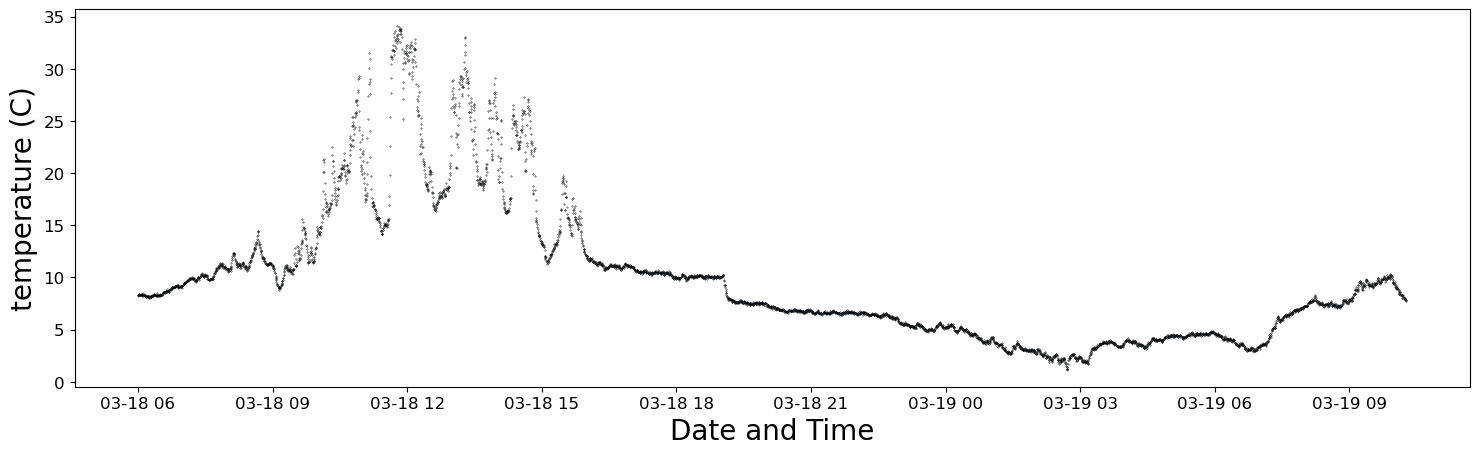

In [56]:
temp_window, time_window = get_dts(channel=300, 
                                   starttime=UTCDateTime(2023, 3, 18, 6, 0, 0), 
                                   endtime=UTCDateTime(2023, 3, 19, 15, 0, 0))

plt.close('all')
plt.figure(figsize = (18, 5), dpi = 100)
plt.scatter(time_window.astype('datetime64[m]'), temp_window, marker='o', s=0.1, edgecolors='k')
plt.ylabel("temperature (C)", fontsize = 20)
plt.xlabel("Date and Time", fontsize = 20)